In [1]:
%run "00-common"
%matplotlib inline

import sklearn as sk
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv('../feature_selection.csv')

In [2]:
X = df.drop("koi_disposition", axis=1)
y = df["koi_disposition"]

(X_train, X_test, y_train, y_test) = sk.model_selection.train_test_split(X, y, test_size=.3, stratify=y, random_state=1)

# Bagging

In [3]:
bg = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_jobs=-1)
bg.fit(X_train, y_train)
pred = bg.predict(X_test)

print("\nConfusion matrix on test set:\n", sk.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ", sk.metrics.accuracy_score(y_test, pred))


Confusion matrix on test set:
 [[389  19]
 [ 33 159]]

Accuracy on test set:  0.9133333333333333


In [4]:
cv = 50
n_estimators = [1, 2, 5, 10, 20, 50, 100, 200]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

param_grid = { 'max_features': max_features, 'n_estimators': n_estimators }

grid_search = GridSearchCV(BaggingClassifier(base_estimator=DecisionTreeClassifier()), param_grid, cv=cv, n_jobs=-1, scoring='f1')
grid_search.fit(X_train, y_train)

scores = grid_search.cv_results_['mean_test_score']


Best combination of parameters found:  {'max_features': 0.9, 'n_estimators': 200}


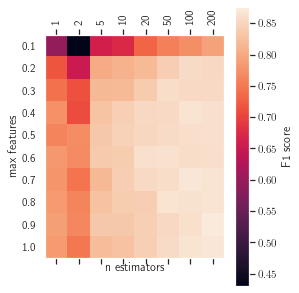

In [5]:
scores = grid_search.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(param_grid['max_features']), len(param_grid['n_estimators']))

plt.matshow(scores)
plt.xlabel('n estimators')
plt.ylabel('max features')
plt.colorbar(label='F1 score')
plt.grid(b=None)
plt.xticks(np.arange(len(param_grid['n_estimators'])), param_grid['n_estimators'], rotation='vertical')
plt.yticks(np.arange(len(param_grid['max_features'])), param_grid['max_features'])

plt.savefig("../figures/bagging.pdf")

parval = grid_search.best_params_
print("\nBest combination of parameters found: ", parval)

In [6]:
bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=parval['n_estimators'], max_features=parval['max_features'])

cvacc = cross_val_score(bag , X=X_train,  y=y_train, cv=cv, scoring='f1', n_jobs=-1)
print('\nF1 score. 50-fold cross on train data= ', cvacc.mean())


F1 score. 50-fold cross on train data=  0.8759819174633415


In [7]:
bag.fit(X_train, y_train)
pred = bag.predict(X_test)

print("\nConfusion matrix on test set:\n", sk.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ", sk.metrics.accuracy_score(y_test, pred))
print("\F1 score on test set: ", sk.metrics.accuracy_score(y_test, pred))


Confusion matrix on test set:
 [[385  23]
 [ 23 169]]

Accuracy on test set:  0.9233333333333333
\F1 score on test set:  0.9233333333333333


In [8]:
import pickle

with open('pickles/bagging.pkl', 'wb') as out:
    pickle.dump(bag, out)